# Building a U-Net: layers definitions

You will construct a U-Net architecture from scratch. Here, you start with defining the __init__() method where you will define layers and blocks of layers for the model to use.

The encoder and transposed convolution and decoder's convolutional blocks. You need to pass the appropriate number of input and output channels to each of them, taking into account the skip connections.

The first block, dec1, will take as input the concatenation of upconv3 output with the enc3 output. The dec1 output, in turn, should be equal to enc3 output.


* Define the three convolutional blocks in the decoder by passing the appropriate number of input and output channels to each of them.

In [1]:
import torch
import torch.nn as nn

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # encoder layers consisting of four convolutional blocks 
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        # Define the decoder blocks
        self.dec1 = self.conv_block(512, 256)
        self.dec2 = self.conv_block(256, 128)
        self.dec3 = self.conv_block(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
        


**Convolutional Blocks**

In [17]:
def conv_block(self, in_channels, out_channels):
    
    return nn.Sequential(
    nn.Conv2d(in_channels, out_channels),
    nn.ReLU(inplace = True),
    nn.Conv2d(out_channels, out_channels),
    nn.ReLU(inplace = True),    
    )

# Building a U-Net: forward method

With the encoder and decoder layers defied, you can now implement the forward() method of the U-net.

The goal of the decoder is to upsample the feature maps so that its output is of the same height and width as the U-Net's input image. This will allow you to obtain pixel-level semantic masks.


Define the last decoder block, using torch.cat() to form the skip connection.

In [12]:
def forward(self, x):
    
    # x is the input the input is passed through the encoder's convolutional blocks 
    x1 = self.enc1(x)
    x2 = self.enc2(self.pool(x1))
    x3 = self.enc3(self.pool(x2))
    x4 = self.enc4(self.pool(x3))

    # decoder part and the skip connections. 
    x = self.upconv3(x4)
    x = torch.cat([x, x3], dim=1)
    x = self.dec1(x)

    x = self.upconv2(x)
    x = torch.cat([x, x2], dim=1)
    x = self.dec2(x)

    # Define the last decoder block with skip connections
    x = self.upconv1(x)
    x = torch.cat([x, x1], dim = 1)
    x = self.dec3(x)
    
    return self.out(x)

# Running semantic segmentation

Good job designing the U-Net! You will find an already pre-trained model very similar to the one you have just built available to you. This model has been trained on a large set of images and contains a few small additions to the architecture, such as the batch norm layers.

You can instantiate the model as UNet(), which will provide the model with the pre-trained weights. You task is to use it to produce segmentation masks for the following image of a car.

**Getting ALL TOGETHER**

In [39]:

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # Define the encoder layers
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the upsampling layers
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        # Define the decoder layers
        self.dec1 = self.conv_block(512, 256)
        self.dec2 = self.conv_block(256, 128)
        self.dec3 = self.conv_block(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:diff_y + target_size[0], diff_x:diff_x + target_size[1]]

    def forward(self, x):
        # Encoding path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Decoding path
        dec3 = self.upconv3(enc4)
        enc3_cropped = self.center_crop(enc3, dec3.shape[2:])
        dec3 = torch.cat((dec3, enc3_cropped), dim=1)
        dec3 = self.dec1(dec3)

        dec2 = self.upconv2(dec3)
        enc2_cropped = self.center_crop(enc2, dec2.shape[2:])
        dec2 = torch.cat((dec2, enc2_cropped), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        enc1_cropped = self.center_crop(enc1, dec1.shape[2:])
        dec1 = torch.cat((dec1, enc1_cropped), dim=1)
        dec1 = self.dec3(dec1)

        out = self.out(dec1)
        return out

* The center_crop method is added to the UNet class. This method crops the input tensor to the target size, ensuring that the dimensions match for concatenation.
* The forward method is modified to use center_crop before concatenating the feature maps from the encoder and decoder paths.

In [45]:
# num_classes = 3
# Load model
model = UNet(in_channels = 3,out_channels = 3)
print(model)
model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, 

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, 

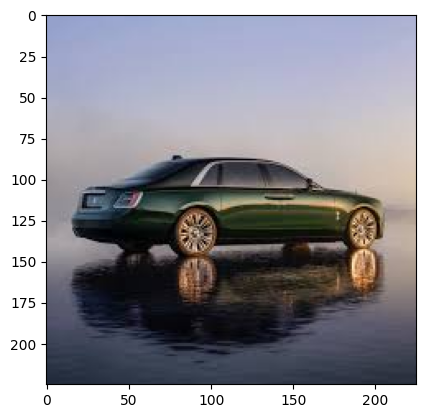

In [46]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Load and transform image
image = Image.open("/kaggle/input/cars-image-dataset/Cars Dataset/train/Rolls Royce/104.jpg")
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

plt.imshow(image)

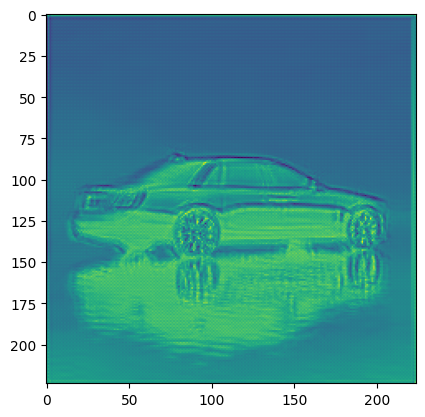

In [48]:
# Predict segmentation mask
with torch.no_grad():
    prediction = model(image_tensor).squeeze(0)

# Display mask
plt.imshow(prediction[1, :, :])
plt.show()

 The mask might not be perfect but remember we are using a model pre-trained on different data. Fine-tuning it no car images should improve the results.